In [5]:
import os, sys, email,re
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
import wordcloud

import networkx as nx

from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output

#stuff from class
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer

In [6]:
df = pd.read_csv('C:/Users/benso/Desktop/Projects/UsableAI/Project/cleaned_enron.csv')

In [21]:
df = df.sample(frac=0.02, random_state=1)


In [22]:
df.head()

,Unnamed: 0,file,message,date,subject,X-Folder,X-From,X-To,body,employee
456708,482513,taylor-m/notes_inbox/405.,Message-ID: <18998565.1075859992762.JavaMail.e...,05-04-2000 13:59:00,Deletion of Your EnronOnline User ID,notes inbox,David Forster,"Amelia Alland, Alan Aronowitz, Anthony Campos,...",Password Deletion\n\nIt has been noted that ma...,taylor-m
310078,328150,mcconnell-m/art/8.,Message-ID: <20215594.1075843929290.JavaMail.e...,17-10-2000 02:58:00,Re: Your Blue Note,art,"""Virginia E. Repasky"" <virginia@clarkfineart.com>",Mike.McConnell@enron.com,Dear Mike:\n\nI wanted to let you know the sta...,mcconnell-m
440446,465500,symes-k/all_documents/3776.,Message-ID: <11837737.1075841708672.JavaMail.e...,01-05-2001 22:52:00,Global Agenda Alert - 2nd May 2001,all documents,"""The Economist"" <global_agenda@lists.economist...",kate.symes@enron.com,[IMAGE]\n[IMAGE]\n\n\t[IMAGE] \n\n\n[IMAGE]\n[...,symes-k
25976,28947,beck-s/inbox/130.,Message-ID: <14017735.1075840357983.JavaMail.e...,09-01-2002 16:39:18,FW: Estate Deal Clearing Systems now in produc...,inbox,"Reeves, Leslie </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Beck, Sally </O=ENRON/OU=NA/CN=RECIPIENTS/CN=S...",\nFYI - this was done ahead of schedule and we...,beck-s
149385,159365,hain-m/discussion_threads/645.,Message-ID: <17863686.1075860401779.JavaMail.e...,21-03-2001 07:53:00,WP-02 Data Response,discussion threads,"""Ferranti, Bill"" <bferranti@mbllp.com>","""'abuckley@wutc.wa.gov'"" <abuckley@wutc.wa.gov...",<<BPA-DS-011.doc>>\n\nAttached is the respons...,hain-m


In [23]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [24]:
data = df.body.values.tolist()

In [25]:

# tokenize - break down each sentence into a list of words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [26]:
data_words = list(sent_to_words(data))

In [28]:
from gensim.models.phrases import Phrases, Phraser

bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

In [29]:
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[200]]])

['jinbaek', 'you', 'can', 'coordinate', 'the', 'details', 'with', 'me', 'let', 'me', 'know', 'what', 'the', 'time_frame', 'is', 'for', 'you', 'and', 'we', 'shall', 'send', 'you', 'an', 'appropriate', 'offer', 'vince', 'jinbaek_kim_jinbaek_ieor', 'berkeley_edu', 'on', 'pm', 'to', 'vince_kaminski', 'enron', 'com', 'cc', 'subject', 're', 'summer_internship', 'dr_kaminski', 'thank', 'you', 'very', 'much', 'of', 'course', 'll', 'be', 'happy', 'to', 'have', 'an', 'opportunity', 'to', 'work', 'at', 'such', 'wonderful', 'company', 'was', 'contacting', 'with', 'surech', 'raghavan', 'at', 'deal', 'bench', 'team', 'and', 'was', 'going', 'to', 'express', 'my', 'appreciation', 'to', 'you', 'again', 'after', 'settling', 'down', 'process', 'with', 'them', 'for', 'the', 'period', 'of', 'working', 'still', 'need', 'to', 'coordinate', 'with', 'my', 'advisor', 'and', 'may', 'need', 'to', 'adjust', 'according', 'to', 'that', 'but', 'anyway', 'll', 'try', 'to', 'coordinate', 'smoothly', 'please', 'let', 'm

In [32]:
from gensim.utils import simple_preprocess

# remove stop_words, make bigrams and lemmatize
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [33]:
data_words_nostops = remove_stopwords(data_words) #remove stopwords

In [34]:
data_words_bigrams = make_bigrams(data_words_nostops)


In [47]:
import spacy

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [48]:
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [49]:
print(data_lemmatized[200])


['jinbaek', 'coordinate', 'detail', 'let', 'know', 'send', 'appropriate', 'offer', 'vince', 'berkeley', 'pm', 'vince_kaminski', 'enron', 'com', 'summer_internship', 'dr', 'kaminski', 'thank', 'much', 'course', 'happy', 'opportunity', 'work', 'wonderful', 'company', 'contact', 'surech', 'raghavan', 'deal', 'bench', 'team', 'go', 'express', 'appreciation', 'settling', 'process', 'period', 'work', 'still', 'need', 'coordinate', 'advisor', 'need', 'adjust', 'accord', 'anyway', 'try', 'coordinate', 'smoothly', 'let', 'know', 'keep', 'contact', 'deal', 'bench', 'team', 'work', 'period', 'misc', 'living', 'support', 'find', 'place', 'rent_car', 'appreciate', 'much', 'arrange', 'meeting', 'give', 'opportunity', 'opportunity', 'available', 'kind', 'help', 'warm', 'regard', 'jinbaek', 'ph_candidate', 'dept', 'industrial_engineere', 'operation', 'research', 'berkeley', 'ieor_berkeley', 'jinbaek', 'go', 'bear', 'vince_kaminski', 'enron', 'com', 'write', 'delay', 'get', 'back', 'like', 'much', 'off

In [103]:
# create dictionary and corpus both are needed for (LDA) topic modeling

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
# Build LDA model
from gensim import models
from gensim.models import ldamodel

lda_model = ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
print(lda_model.print_topics())# The weights reflect how important a keyword is to that topic.


[(0, '0.017*"http" + 0.015*"class" + 0.011*"email" + 0.011*"click" + 0.011*"free" + 0.009*"way" + 0.009*"offer" + 0.009*"news" + 0.008*"day" + 0.008*"image"'), (1, '0.023*"company" + 0.020*"business" + 0.012*"new" + 0.010*"service" + 0.010*"say" + 0.008*"year" + 0.007*"market" + 0.007*"group" + 0.006*"program" + 0.006*"stock"'), (2, '0.368*"enron" + 0.051*"ee" + 0.043*"corp" + 0.017*"communication" + 0.016*"pm" + 0.011*"et" + 0.009*"forward" + 0.008*"cc" + 0.008*"enronxgate" + 0.006*"john"'), (3, '0.347*"com" + 0.047*"mail" + 0.020*"message" + 0.019*"email" + 0.015*"aol" + 0.014*"net" + 0.014*"mailto" + 0.011*"hotmail" + 0.010*"businessweek" + 0.010*"receive"'), (4, '0.021*"get" + 0.019*"send" + 0.019*"know" + 0.017*"go" + 0.014*"thank" + 0.012*"let" + 0.011*"call" + 0.011*"good" + 0.011*"time" + 0.010*"want"'), (5, '0.010*"change" + 0.010*"agreement" + 0.009*"information" + 0.009*"question" + 0.009*"review" + 0.009*"issue" + 0.008*"need" + 0.008*"attach" + 0.008*"request" + 0.008*"fol

In [110]:
lda_model.show_topic(9)

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('pm', 0.027487203),
 ('game', 0.016865674),
 ('sit', 0.01674463),
 ('sun', 0.013242903),
 ('attempt', 0.013113224),
 ('play', 0.012588036),
 ('scheduled_outage', 0.011765451),
 ('error_occurre', 0.011144606),
 ('engine_error', 0.011144606),
 ('initialize', 0.011144606)]

In [111]:
doc_lda = lda_model[corpus]


C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Perplexity:  -8.990211366235282


In [113]:
# Compute Coherence Score
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Coherence Score:  0.5367828804024949


In [114]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()    
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.8708,"change, agreement, information, question, review, issue, need, attach, request, follow","[password, deletion, note, many, user, password, match, similar, internal, enrononline, applicat..."
1,1,4.0,0.4616,"get, send, know, go, thank, let, call, good, time, want","[dear, mike, want, let, know, status, artwork, blue, note, receive, artwork, house, late, friday..."
2,2,0.0,0.4070,"http, class, email, click, free, way, offer, news, day, image","[wednesday, nd, subscribe, mail, mobile, edition, screensaver, image_image, image, opinion, worl..."
3,3,4.0,0.4182,"get, send, know, go, thank, let, call, good, time, want","[fyi, do, ahead, schedule, sign, estate, app, question, let, know, thank, original_message, scho..."
4,4,5.0,0.4708,"change, agreement, information, question, review, issue, need, attach, request, follow","[attach, response, bpa, bill, ferranti, murphy, buchal, llp, bferranti, mbllp, com, bpa, doc]"
5,5,2.0,0.5346,"enron, ee, corp, communication, pm, et, forward, cc, enronxgate, john","[forward, jane_tholt, hou, ect, pm, enron, tk_lohman, enron, pm, jane_tholt, enron, com, tw, opt..."
6,6,9.0,0.2862,"pm, game, sit, sun, attempt, play, scheduled_outage, error_occurre, engine_error, initialize","[miss, deal, tom, sell, srp, sell, sempra, feb, mw, sp, buy, sempra, feb, mw, thank]"
7,7,5.0,0.4148,"change, agreement, information, question, review, issue, need, attach, request, follow","[debra, charlie, wojta, reference, company, agree, gisb, base, contract, amend, designate, ena, ..."
8,8,1.0,0.3380,"company, business, new, service, say, year, market, group, program, stock","[enrononline, pass, transaction, woohoo, also, issue, enron, com, fabulously, new, improve, enro..."
9,9,0.0,0.2431,"http, class, email, click, free, way, offer, news, day, image","[start, build, realestate, empire, today, always, intrigue, idea, invest, think, lack, money, kn..."


In [63]:
# Visualize the topics
import pyLDAvis
from pyLDAvis import gensim

pyLDAvis.enable_notebook(sort=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8000,"http, class, email, click, free, way, offer, news, day, image","[information_containe, herein, base, source, believe, reliable, represent, accurate, complete, h..."
1,1.0,0.6750,"company, business, new, service, say, year, market, group, program, stock","[venturewire, thursday, september, private, company, business, news, publish, daily, technologic..."
2,2.0,0.8380,"enron, ee, corp, communication, pm, et, forward, cc, enronxgate, john","[believe, intend, et, trading, thank, enron, enronxgate, pm, daniel_allegretti, enron, enron, na..."
3,3.0,0.8120,"com, mail, message, email, aol, net, mailto, hotmail, businessweek, receive","[note, forward, message, attach, get, email, domain, yahoo, mail, http, personal, mail, yahoo, c..."
4,4.0,0.8997,"get, send, know, go, thank, let, call, good, time, want","[estate, goofy, tell, much, estate, send, tuesday, february, pm, mean, send, tuesday, february, ..."
5,5.0,0.8708,"change, agreement, information, question, review, issue, need, attach, request, follow","[password, deletion, note, many, user, password, match, similar, internal, enrononline, applicat..."
6,6.0,0.8874,"font, td, br, td_align, href, right, table, font_size, iso, br_br","[start, date_hourahead, hour, awarded_variance, detected_variance, detect, generation, schedule,..."
7,7.0,0.8866,"ect, hou, cc, pm, forward, deal, lon, corp, pdx, vince_kaminski","[shirt, size, large, pm, ect, ect, hou, ect, ect, hou, ect, ect, bob_carter, hou, ect, ect, mary..."
8,8.0,0.7678,"power, price, say, market, energy, state, california, rate, cost, utility","[john, let, know, need, anything_else, market, trading, winter, summer, run, cal, arnold, mil, m..."
9,9.0,0.9672,"pm, game, sit, sun, attempt, play, scheduled_outage, error_occurre, engine_error, initialize","[start, date_hourahead, hour, hourahead, schedule, download_faile, manual_intervention, require,..."


C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


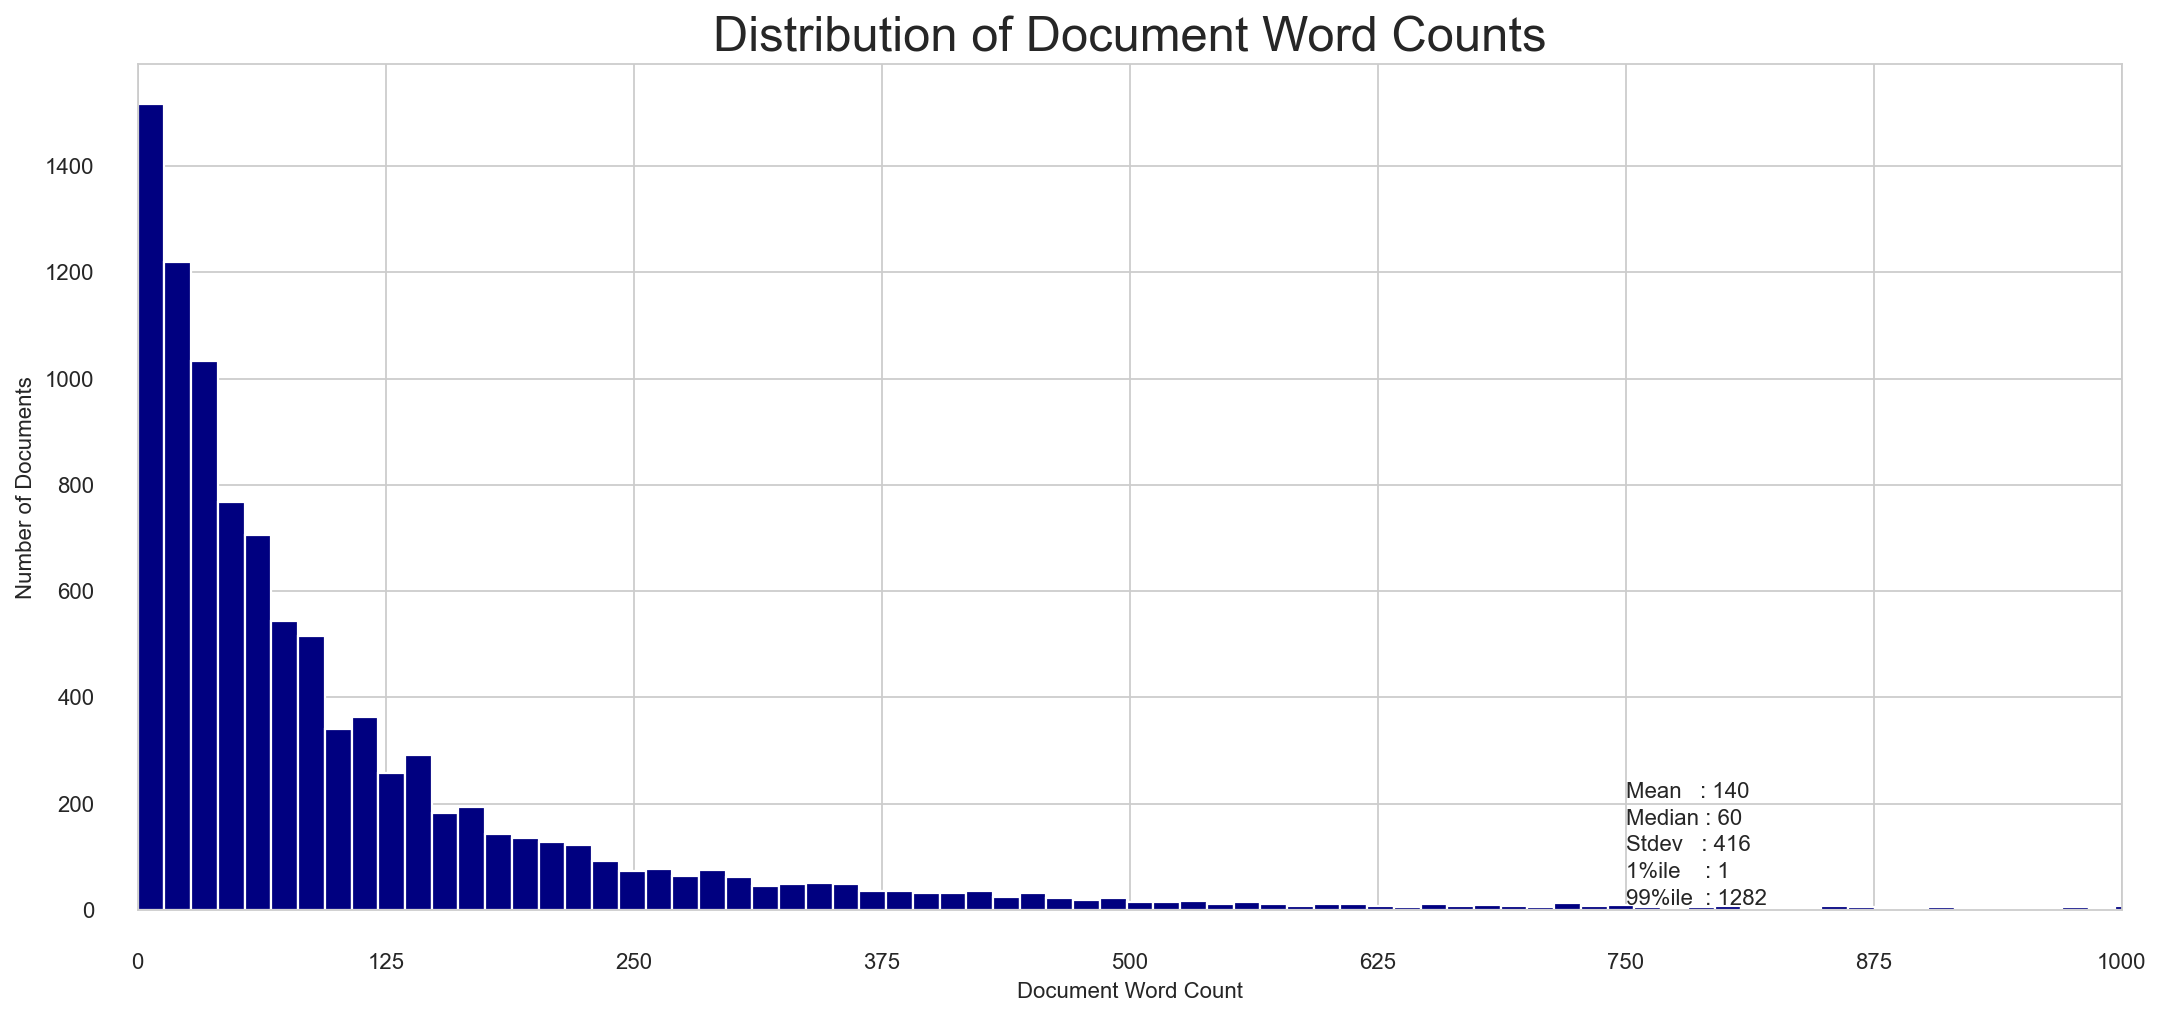

In [116]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 210, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  160, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  110, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  60, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  10, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig("C:/Users/benso/Desktop/Projects/Usable_AI_Code/Project/doc_word_counts.png")
plt.show()

In [117]:
#most discussed words in the documents

# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [118]:
df_top3words

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_id,words
0,0,"http, \nclass, \nemail"
1,1,"company, \nbusiness, \nnew"
2,2,"enron, \nee, \ncorp"
3,3,"com, \nmail, \nmessage"
4,4,"get, \nsend, \nknow"
5,5,"change, \nagreement, \ninformation"
6,6,"font, \ntd, \nbr"
7,7,"ect, \nhou, \ncc"
8,8,"power, \nprice, \nsay"
9,9,"pm, \ngame, \nsit"


In [119]:
df_top3words.loc[df_top3words.topic_id==0, 'words'].values[0]

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'http, \nclass, \nemail'

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


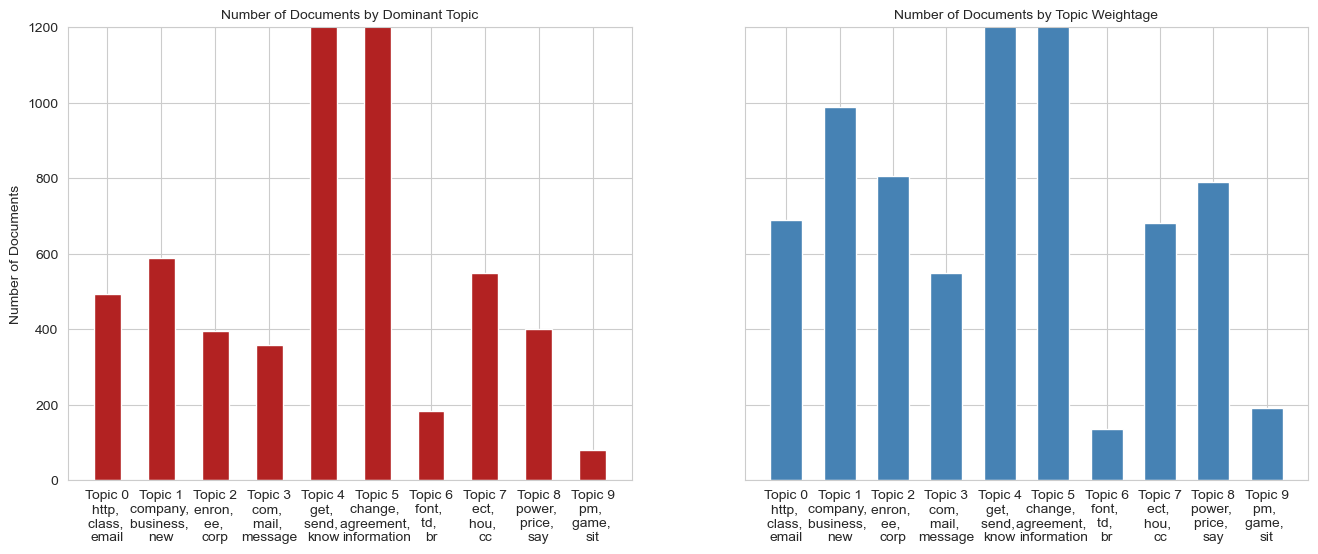

In [124]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1200)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.6, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.savefig("C:/Users/benso/Desktop/Projects/Usable_AI_Code/Project/doc_counts_topic.png")

plt.show()

In [130]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from bokeh.io import export_png


# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
#plot.savefig("C:/Users/benso/Desktop/Projects/Usable_AI_Code/Project/cluster_topics.png")
export_png(plot, filename="C:/Users/benso/Desktop/Projects/Usable_AI_Code/Project/cluster_topics.png")
show(plot)


C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6698 samples in 0.019s...
[t-SNE] Computed neighbors for 6698 samples in 0.438s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6698
[t-SNE] Computed conditional probabilities for sample 2000 / 6698
[t-SNE] Computed conditional probabilities for sample 3000 / 6698
[t-SNE] Computed conditional probabilities for sample 4000 / 6698
[t-SNE] Computed conditional probabilities for sample 5000 / 6698
[t-SNE] Computed conditional probabilities for sample 6000 / 6698
[t-SNE] Computed conditional probabilities for sample 6698 / 6698
[t-SNE] Mean sigma: 0.000018
[t-SNE] KL

Loading BokehJS ...

In [132]:
N = 10
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(arr)

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [134]:
#wordvector_fit_2d = arr.todense()
pca = PCA(n_components=2).fit(arr)
datapoint = pca.transform(arr)

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


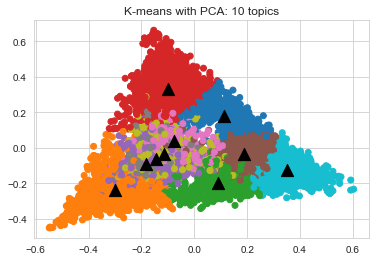

In [140]:
label = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.title("K-means with PCA: 10 topics")
plt.savefig("C:/Users/benso/Desktop/Projects/Usable_AI_Code/Project/KMeans.png")
plt.show()

C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


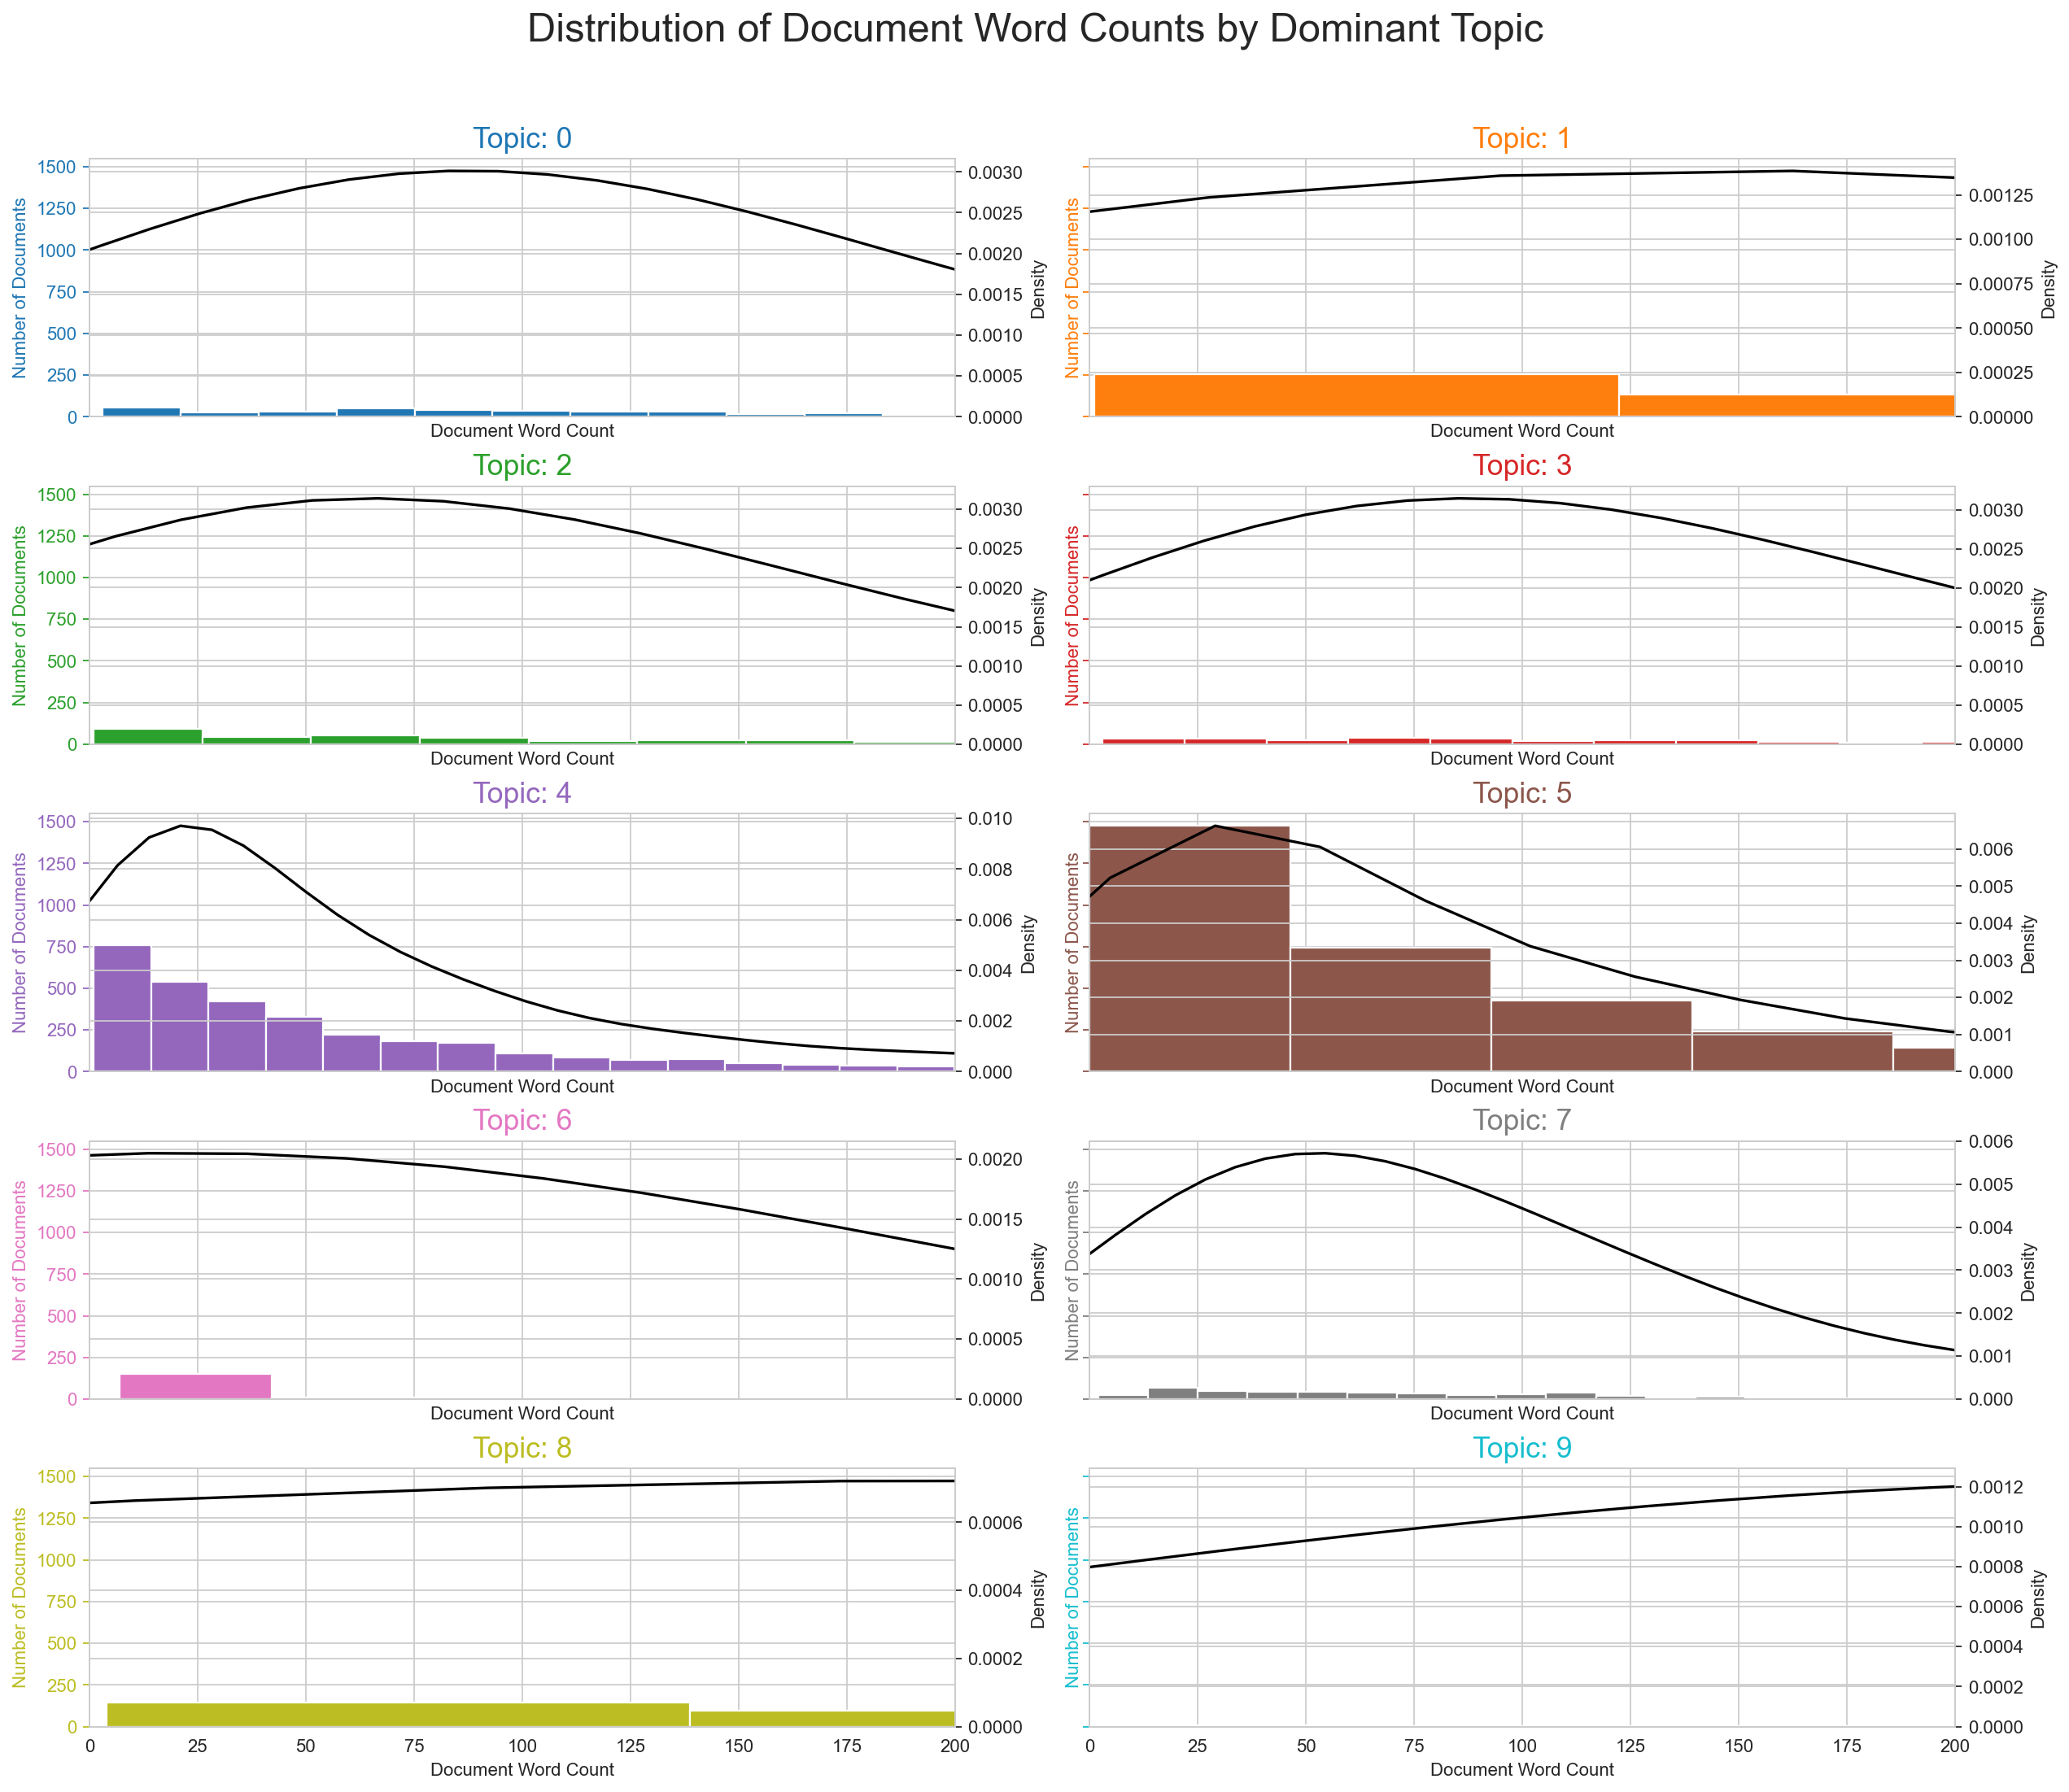

In [131]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 200), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,200,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [64]:
pyLDAvis.display(vis)


C:\Users\benso\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
